# Human-in-the-loop

Hướng dẫn này bao gồm **Human in the loop** (Con người trong vòng lặp).

Các agent không phải lúc nào cũng đáng tin cậy và sự can thiệp của con người có thể cần thiết để đảm bảo các tác vụ được thực hiện thành công.

Trong một số trường hợp, bạn có thể muốn sự chấp thuận của con người trước khi tiếp tục để xác nhận rằng mọi thứ đang hoạt động như dự định. LangGraph hỗ trợ các quy trình làm việc **Human-in-the-loop** này.

Trong hướng dẫn này, bạn sẽ học cách sử dụng tính năng `interrupt_before` của LangGraph để tạm dừng quá trình thực thi, cho phép sự giám sát và kiểm soát của con người.


## Function Setup

Convenient functions for smooth execution.

In [1]:
import feedparser
from urllib.parse import quote # mã hóa các ký tự đặc biệt trong một chuỗi để nó trở thành định dạng an toàn khi dùng trong URL
from typing import List, Dict, Optional

class GoogleNews:
    """
    A class to search Google News
    """
    def __init__(self) -> None:
        """
        Init the base url
        """
        self.base_url = "https://news.google.com/rss"
    
    def _fetch_news(self, url: str, k: int = 3) -> List[Dict[str, str]]:
        """
        Fetches news from the given URL.
        """
        news_data = feedparser.parse(url)
        return [
            {"title": entry.title, "link": entry.link}
            for entry in news_data.entries[:k]
        ] # type: ignore
    
    def _collect_news(self, news_list: List[Dict[str, str]]) -> List[Dict[str, str]]:
        """
        Organizes and returns the news list
        """
        if not news_list:
            print("No news found for the given keywords")
            return []
        
        result = []
        for news in news_list:
            result.append({"url": news["link"], "content": news["title"]})

        return result
    
            
    def search_latest(self, k: int = 3) -> List[Dict[str, str]]:
        """
        Searches for the latest news.
        """
        url = f"{self.base_url}?hl=vi&gl=VN&ceid=VN%3Avi"
        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)

    def search_by_keyword(
        self, keyword: Optional[str] = None, k: int = 3
    ) -> List[Dict[str, str]]:
        """
        Searches for news by keyword.
        """
        if keyword:
            encoded_keyword = quote(keyword)
            url = f"{self.base_url}/search?q={encoded_keyword}&hl=vi&gl=VN&ceid=VN%3Avi"
        else:
            url = f"{self.base_url}?hl=vi&gl=VN&ceid=VN%3Avi"
        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)        

In [2]:
test_url = "https://news.google.com/rss/?hl=vi&gl=VN&ceid=VN%3Avi"
result = feedparser.parse(test_url)

In [3]:
result.entries[0]

{'title': 'Video UAV Ukraine vượt mặt hệ thống phòng không Nga, bắn nổ nhiều mục tiêu - VietNamNet',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://news.google.com/rss?hl=vi&gl=VN&ceid=VN:vi',
  'value': 'Video UAV Ukraine vượt mặt hệ thống phòng không Nga, bắn nổ nhiều mục tiêu - VietNamNet'},
 'links': [{'rel': 'alternate',
   'type': 'text/html',
   'href': 'https://news.google.com/rss/articles/CBMirAFBVV95cUxQeC00SkRrZ0UyUzJGSEtIcml6ODZEVi1peHdOckU2NjFWSEdscUhrZzRhRjZ0NzhvN2ZtcWZNZXVHTmZkdnF0ejVvTHVqeDNESWlFLU5ZUWd3NE0xUnpSYV9pd2ZJeC12dUo2T3ZOb0hjVU00SnhmLU83TDBrR3l6U3dNZi1xWEFDQ010eXlva3pYOTk5ZFBaeXpCM1ZodWVjYnp4bUV1c3Rib0dL?oc=5'}],
 'link': 'https://news.google.com/rss/articles/CBMirAFBVV95cUxQeC00SkRrZ0UyUzJGSEtIcml6ODZEVi1peHdOckU2NjFWSEdscUhrZzRhRjZ0NzhvN2ZtcWZNZXVHTmZkdnF0ejVvTHVqeDNESWlFLU5ZUWd3NE0xUnpSYV9pd2ZJeC12dUo2T3ZOb0hjVU00SnhmLU83TDBrR3l6U3dNZi1xWEFDQ010eXlva3pYOTk5ZFBaeXpCM1ZodWVjYnp4bUV1c3Rib0dL?oc=5',
 'id': 'CBMirAFBVV95cUxQeC00Sk

In [4]:
keyword = "Giá nhà chung cư Hà Đông"

base_url = "https://news.google.com/rss"
encoded_keyword = quote(keyword)
url = f"{base_url}/search?q={encoded_keyword}&hl=vi&gl=VN&ceid=VN%3Avi"
url

'https://news.google.com/rss/search?q=Gi%C3%A1%20nh%C3%A0%20chung%20c%C6%B0%20H%C3%A0%20%C4%90%C3%B4ng&hl=vi&gl=VN&ceid=VN%3Avi'

In [5]:
news2 = feedparser.parse(url)
news2.entries[:3]

[{'title': "Chung cư ở Hà Nội đã bàn giao 4-5 năm cũng tăng giá như 'lên đồng' - Báo Tuổi Trẻ",
  'title_detail': {'type': 'text/plain',
   'language': None,
   'base': 'https://news.google.com/rss/search?q=Gi%C3%A1%20nh%C3%A0%20chung%20c%C6%B0%20H%C3%A0%20%C4%90%C3%B4ng&hl=vi&gl=VN&ceid=VN%3Avi',
   'value': "Chung cư ở Hà Nội đã bàn giao 4-5 năm cũng tăng giá như 'lên đồng' - Báo Tuổi Trẻ"},
  'links': [{'rel': 'alternate',
    'type': 'text/html',
    'href': 'https://news.google.com/rss/articles/CBMiqAFBVV95cUxPUEU5eG1OX3Y4bXdFblI5ZW8xU21XS0NCcVEtWlZUbEhQSk4xZ2RYRjRlQ0dXemlNMmJHY3o0UXFDdUJVR0ZHcE1Ga0JBNFhpOUcyTmx2b3JLLUxDNXZLa25mZUVOZjliMjZyaTBJc3N2dXRIQWtIODBWQzNLb3hJNk9icmc5elVGa3JtOTFHT2RqQUhUdlNaN21jQWU5US0wWS1PQ0NGa2g?oc=5'}],
  'link': 'https://news.google.com/rss/articles/CBMiqAFBVV95cUxPUEU5eG1OX3Y4bXdFblI5ZW8xU21XS0NCcVEtWlZUbEhQSk4xZ2RYRjRlQ0dXemlNMmJHY3o0UXFDdUJVR0ZHcE1Ga0JBNFhpOUcyTmx2b3JLLUxDNXZLa25mZUVOZjliMjZyaTBJc3N2dXRIQWtIODBWQzNLb3hJNk9icmc5elVGa3JtOTFHT2RqQUhUdl

In [6]:
from langchain_core.messages import BaseMessage

def pretty_print_messages(messages: list[BaseMessage]):
    for message in messages:
        message.pretty_print()

## Graph Setup

This setup initializes a graph-based workflow for a chatbot, defining the state, tools, and nodes while establishing edges and a memory saver for persistent interactions.

In [7]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_ollama import ChatOllama
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


###### Define the State ######
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


###### Define the tool and binding ######
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """
    Look up news by keyword.
    """
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]
llm = ChatOllama(model='qwen2.5:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)


###### Add Nodes ######
def chatbot(state: State):
    """
    Invoke the message and return the result.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# chatbot node
graph_builder.add_node("chatbot", chatbot)

# tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# conditional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)


###### Add Edges ######
# tools -> chatbot
graph_builder.add_edge("tools", "chatbot")

# START -> chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot -> END
graph_builder.add_edge("chatbot", END)


###### Add the MemorySaver ######
memory = MemorySaver()

In [8]:
graph = graph_builder.compile(checkpointer=memory)

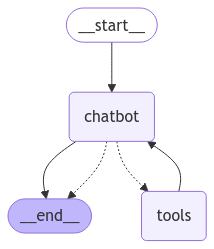

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Adding Human Feedback

Let's now perform **Human-in-the-loop** !

In [10]:
from langchain_core.runnables import RunnableConfig

# User input
question = "Có nên mua nhà Chung cư tại thời điểm này hay không? Tìm kiếm thông tin sử dụng tools trước khi đưa ra câu trả lời."

input = State(messages=[("user", question)])

# Configure seting
config = RunnableConfig(
    recursion_limit=10,
    configurable={'thread_id': 1},
    tags=['gia-nha-chung-cu-ha-noi']
)

for event in graph.stream(input=input, config=config, stream_mode='values', interrupt_before=['tools']):
    for key, value in event.items():
        pretty_print_messages(value)
        if "messages" in value:
            print(f"Number of messages: {len(value['messages'])}")

================================ Human Message =================================

Có nên mua nhà Chung cư tại thời điểm này hay không? Tìm kiếm thông tin sử dụng tools trước khi đưa ra câu trả lời.
================================ Human Message =================================

Có nên mua nhà Chung cư tại thời điểm này hay không? Tìm kiếm thông tin sử dụng tools trước khi đưa ra câu trả lời.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (e3923585-5669-4187-9235-e08468fa62a1)
 Call ID: e3923585-5669-4187-9235-e08468fa62a1
  Args:
    query: thị trường bất động sản chung cư


In [11]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Lý do cho sự gián đoạn là vì chúng ta đặt `tools` trong `interrupt_before` trong khi streaming graph, khiến quá trình dừng lại trước khi thực thi node `tools`. Do đó, node tiếp theo (`.next`) trở thành `tools`.

Ngoài ra, *trong hướng dẫn trước*, `.next` trống vì quá trình đã đạt đến node `END` cuối cùng. Tuy nhiên, với interrupt được đặt, `.next` bây giờ được đặt thành `tools`.


Now, let's check the last message in the snapshot!

In [14]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'search_keyword',
  'args': {'query': 'thị trường bất động sản chung cư'},
  'id': 'e3923585-5669-4187-9235-e08468fa62a1',
  'type': 'tool_call'}]

Next, let's resume the graph from the point where it was interrupted.

**LangGraph** makes it easy to resume graph execution.

Simply pass `None` as the `input` .

In [15]:
events = graph.stream(
    input=None,  # Do not add anything to the current State
    config=config,
    stream_mode="values",
)

# Process events in a loop
for event in events:
    if "messages" in event:
        # Print the last message
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (e3923585-5669-4187-9235-e08468fa62a1)
 Call ID: e3923585-5669-4187-9235-e08468fa62a1
  Args:
    query: thị trường bất động sản chung cư
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMilAFBVV95cUxOYmk1dEttejJTZlFZc3JYOXBiQ2ZXWjl2c0JkNklUWDZFTk9vOUJ1RENIa3lPXzJwWnlRTThKLVVZalRkU0xkWmdJQl9vckhrYUdOcmtTcXlCdnF5YUUzQTd6YjNEMnpyQzNTNm02M013V3Y4Y091SnJ2NUJ0TlM1WUNFTU9kWTEtanhIc3Vzc0ZZZXNo?oc=5", "content": "Thị trường bất động sản có dấu hiệu phục hồi - Báo điện tử Quân đội nhân dân"}, {"url": "https://news.google.com/rss/articles/CBMilwFBVV95cUxPWDVOSnI3QUgtb0lMakNoSjdsT2JlX2UxS2czdkxubzFCZU96MGxiaUpwaXNHQTlzUXFQNkZveURIZU1EVHhJMjM5TFhucnA5cWozdTJiUV9jOXc0ejJSSl9vdE50dURPRGZEX1ZINEhLUHRkSkNIRVVmbk5GbzMwYWFGQ2RYRVF1WTNoNlZMSUpoZFZNcXE0?oc=5", "content": "Năm 2025 thị trường bất 

Chúng ta đã sử dụng **interrupt** để cho phép **human intervention** (sự can thiệp của con người) trong quá trình thực thi của chatbot.

Ngoài ra, với việc bao gồm `checkpointer`, graph có thể tiếp tục thực thi ngay cả sau khi bị tạm dừng vô thời hạn.

Dưới đây là cách bạn có thể sử dụng `get_state_history` để truy xuất lịch sử trạng thái.

Bằng cách chỉ định trạng thái mong muốn từ lịch sử, bạn có thể khởi động lại quá trình thực thi từ điểm đó.


In [ ]:
to_replay = None

# Retrieve state history
for state in graph.get_state_history(config):
    print(
        "Number of messages:", len(state.values["messages"]), "\nNext node:", state.next
    )
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        to_replay = state

Number of messages: 4 
Next node: ()
--------------------------------------------------------------------------------
Number of messages: 3 
Next node: ('chatbot',)
--------------------------------------------------------------------------------
Number of messages: 2 
Next node: ('tools',)
--------------------------------------------------------------------------------
Number of messages: 1 
Next node: ('chatbot',)
--------------------------------------------------------------------------------
Number of messages: 0 
Next node: ('__start__',)
--------------------------------------------------------------------------------


In [18]:
display(to_replay.next)

('chatbot',)

In [19]:
display(to_replay.config)

{'configurable': {'thread_id': 1,
  'checkpoint_ns': '',
  'checkpoint_id': '1f007836-5ce0-6fe8-8002-45f62ca9549e'}}

Using this `checkpoint_id` , LangGraph's checkpointer can load the state at that specific point. 

Note that the `input` must be set to `None` in this case.

In [20]:
for event in graph.stream(input=None, config=to_replay.config, stream_mode="values"):
    if "messages" in event:
        # Print the last message
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMilAFBVV95cUxOYmk1dEttejJTZlFZc3JYOXBiQ2ZXWjl2c0JkNklUWDZFTk9vOUJ1RENIa3lPXzJwWnlRTThKLVVZalRkU0xkWmdJQl9vckhrYUdOcmtTcXlCdnF5YUUzQTd6YjNEMnpyQzNTNm02M013V3Y4Y091SnJ2NUJ0TlM1WUNFTU9kWTEtanhIc3Vzc0ZZZXNo?oc=5", "content": "Thị trường bất động sản có dấu hiệu phục hồi - Báo điện tử Quân đội nhân dân"}, {"url": "https://news.google.com/rss/articles/CBMilwFBVV95cUxPWDVOSnI3QUgtb0lMakNoSjdsT2JlX2UxS2czdkxubzFCZU96MGxiaUpwaXNHQTlzUXFQNkZveURIZU1EVHhJMjM5TFhucnA5cWozdTJiUV9jOXc0ejJSSl9vdE50dURPRGZEX1ZINEhLUHRkSkNIRVVmbk5GbzMwYWFGQ2RYRVF1WTNoNlZMSUpoZFZNcXE0?oc=5", "content": "Năm 2025 thị trường bất động sản sẽ sôi động trở lại - Báo Sài Gòn Giải Phóng"}, {"url": "https://news.google.com/rss/articles/CBMi2wFBVV95cUxOdllEOWxwV05YU2ZvZzExelFtcVlUM1NqbGYtWWNWa0NNWXVpSWs0SkxZRGdqV05ZaHdMTUFfaHFMeFRTRFExcTNLckxuWi11ZzctOGFhMzA1SFIyRnBLeThrWFIwdWVoQ